In [1]:
import sys
sys.path.append('code/')
from gwBackground import *
from geometry import *
from makeDelayedRateData import *
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('../plotting.mplstyle')
from scipy.special import gammainc
#from tqdm.notebook import tqdm

plt.rc('text', usetex=True)

from astropy.cosmology import Planck18
import astropy.constants as const
import astropy.units as u

blue = "#1f78b4"
green = "#33a02c"
red = "#e31a1c"

ModuleNotFoundError: No module named 'jax'

In [2]:
year = 365.25*24*3600
H0 = Planck18.H0.to(u.s**(-1)).value

OmgM = Planck18.Om0
OmgL = Planck18.Ode0
rhoC = Planck18.critical_density(0)

31557600.0
2.192711267238057e-18
0.30966
0.6888463055445441
8.598814256622893e-30 g / cm3


# 0. Preliminaries

As a preliminary, precompute some data that gives us star formation rates and evolutionary time delays at a variety of redshifts.
Specifically, the cell below defines the following arrays:

   * `zs_merger` : An array (length M) of possible redshifts at which binaries might merge
   * `time_delays` : An array (length N) of possible source-frame time delays between binary formation and merger. Time delays are in units of Gyr
   * `zs_formation` : A 2D array (length MxN) that gives the *formation* redshift implied by each pair of merger redshifts and evolutionary time delays from `zs_merger` and `time_delays`
   * `formationRates` : An estimate of the global star formation rate (arbitrary overall normalization) at each redshift in `zs_formation`

In [3]:
rateData = generateTimeDelayData()
zs_merger = rateData['zs']
time_delays = rateData['tds']
zs_formation = rateData['formationRedshifts']
formationRates = rateData['formationRates']

Also import data defining the "power-law integrated sensitivity curves" (PI curves) for the O3 and (projected) O4 observing runs:

In [4]:
O3_PI_freqs,O3_PI = np.loadtxt('../input/O3PICurve.dat',unpack=True,usecols=(0,2),skiprows=4)
design_PI_freqs,design_PI = np.loadtxt('../input/Design_HLV_flow_10.txt',unpack=True,usecols=(0,1))

Next, instantiate an `OmegaGW_BBH` object to help us calculate the expected stochastic background for a variety of birefringence cases. Specifically, the arguments below tell us to consider a BBH population with component masses between 2-100 solar masses and situated across the range of redshifts spanned by `zs_merger`. Later on we will tell the object what specific mass and redshift distributions to assume when integrating across this mass and redshift range; the `gridSize` argument pertains to how precisely this integral is done across BBH masses.

**Note**: This might take a few minutes to run...

In [5]:
# Instantiate SGWB calculator
m_absolute_min = 2.
m_absolute_max = 100.
omg = OmegaGW_BBH(m_absolute_min,m_absolute_max,zs_merger,gridSize=(30,29))

Now that we have our stochastic background calculator ready, choose an assumed BBH mass distribution. This is done by choosing values for the following parameters:
   * `m_min`: Minimum BBH mass
   * `m_max`: Maximum BBH mass
   * `alpha`: Power-law index governing the bulk distribution of BBH component masses
   * `mu_peak`: Mean location of an additional Gaussian peak, on top of the bulk power law
   * `sig_peak`: Standard deviation of the Gaussian peak
   * `frac_peak`: Mixture fraction of events belonging to the Gaussian peak
   * `bq`: Power-law index governing the mass ratio distribution of BBHs

In [6]:
# Define hyperparameters describing mass distribution
m_min = 8.
m_max = 100.
alpha = -3.
mu_peak = 35.
sig_peak = 5.
frac_peak = 0.05
bq = 2

# Pass these to our SGWB calculator
omg.setProbs_plPeak(m_min,m_max,alpha,mu_peak,sig_peak,frac_peak,bq)

Finally, define a few different models for the BBH merger rate as a function of redshift:

   1. A constant-in-comoving-volume merger rate density out to $z=6$
   2. A merger rate following the Madau+Dickinson fit for global star formation
   3. A merger rate following a model for the rate of *low metallicity* star formation, subject to a distribution of evolutionary time delays between binary formation and merger

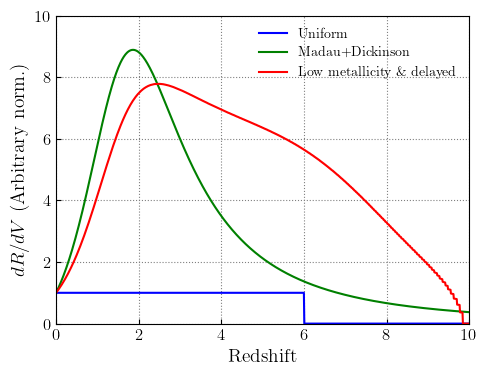

In [7]:
# Regardless of the evolutionary model considered, assume a fixed local merger rate (units 1/Gpc**3/yr)
R0 = 20.

# ==================================
# Case 1: Uniform-in-comoving volume
# ==================================

dRdV_uniform = np.ones(zs_merger.size)
dRdV_uniform[zs_merger>6] = 0

# ======================================
# Case 2: Madau+Dickinson overall rate
# ======================================

alpha = 2.7
beta = 5.6
zpeak = 1.9
dRdV_md = np.power(1.+zs_merger,alpha)/(1.+np.power((1.+zs_merger)/(1.+zpeak),beta))
dRdV_md /= dRdV_md[0]

# =====================================================
# Case 3: Low-metallicity with time delay distribution
# =====================================================

# The following function is an approximation to the integrated fraction of star formation below
# Z=Z_sun/10 as a function of redshift
low_Z_fraction = gammainc(0.84,(0.1**2.)*np.power(10.,0.3*zs_formation))

# Multiply by total formation rate to get the rate of low metallicity star formation
weightedFormationRates = formationRates*low_Z_fraction

# Convolve formation rate with time-delay distribution
# Set t_min = 10 Myr
tdMin = 0.01
dpdt = np.power(time_delays,-1)
dpdt[time_delays<tdMin] = 0.
dRdV_lowZdelayed = weightedFormationRates.dot(dpdt)
dRdV_lowZdelayed /= dRdV_lowZdelayed[0]

# Plot
fig,ax = plt.subplots(figsize=(5.33,4))
ax.plot(zs_merger,dRdV_uniform,color='blue',label='Uniform')
ax.plot(zs_merger,dRdV_md,color='green',label='Madau+Dickinson')
ax.plot(zs_merger,dRdV_lowZdelayed,color='red',label='Low metallicity \& delayed')
ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.legend(loc='upper right',frameon=False,fontsize=10)
ax.set_xlabel('Redshift')
ax.set_ylabel('$dR/dV$ (Arbitrary norm.)')
plt.show()

To evaluate an actual stochastic background spectrum, use the `eval` method of our SGWB calculator. The arguments are, in order,
   * A local merger rate at $z=0$ (units $\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}$)
   * An array (of arbitrary normalization) that traces evolution in the local merger rate with redshift. Note that this needs to be defined on the same grid of redshifts we used when we instantiated our `OmegaGW_BBH` object
   * An array of frequencies at which we want to evaluate the background
   * A "comoving distance" birefringent kappa (units $\mathrm{Gpc}^{-1}$)
   * A "redshift" biregringent kappa
The result will be two energy-density spectra, one each for Stokes I and V.

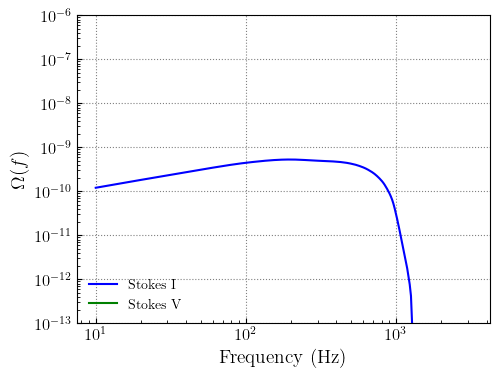

In [8]:
freqs = np.logspace(1,3.5,300)
kappa_dc = 0.
kappa_z = 0.
Omega_I_f,Omega_V_f = omg.eval(R0,dRdV_uniform,freqs,kappa_dc,kappa_z)

fig,ax = plt.subplots(figsize=(5.33,4))
ax.plot(freqs,Omega_I_f,label='Stokes I',color='blue')
ax.plot(freqs,Omega_V_f,label='Stokes V',color='green')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel("$\Omega(f)$")
ax.legend(loc='lower left',frameon=False,fontsize=10)
ax.set_ylim(1e-13,1e-6)
plt.show()

## Get other PI curves - load from .txt files defining sigmas 

In [10]:
def pi_curve(frequencies,sigmas,alpha_min,alpha_max):

    # Range of power-law indices
    alphas = np.linspace(alpha_min,alpha_max,30)
    amplitudes = np.zeros(alphas.size)

    # Loop across indices
    for i,alpha in enumerate(alphas):

        # Compute power-law model with a reference amplitude of one
        omega_unscaled = np.power(frequencies/25.,alpha)

        # Compute reference snr
        reference_snr = np.sqrt(np.sum(omega_unscaled**2/sigmas**2))
        detectable_amp = 1./reference_snr
        amplitudes[i] = detectable_amp

    # Define arrays holding all power-laws
    power_law_locus = np.array([amplitudes[i]*(frequencies/25.)**alphas[i] for i in range(alphas.size)])

    pi = np.max(power_law_locus,axis=0)
    return pi

In [11]:
freqs_Asharp, sigmas_Asharp = np.loadtxt('SigmasAsharp.txt', unpack=True, skiprows=1)
freqs_CE, sigmas_CE = np.loadtxt("SigmasCE.txt",  unpack=True, skiprows=1)


In [12]:
H1L1 = Baseline(Detector.H1(),Detector.L1())
H1V1 = Baseline(Detector.H1(),Detector.V1())
H1L1_gammaI,H1L1_gammaV = H1L1.stokes_overlap_reduction_functions(freqs_Asharp)
H1L1CE_gammaI,H1L1CE_gammaV = H1L1.stokes_overlap_reduction_functions(freqs_CE)

In [13]:
Asharp_pi = pi_curve(freqs_Asharp,sigmas_Asharp/H1L1_gammaI,-8,8)
CE_pi = pi_curve(freqs_CE, sigmas_CE/H1L1CE_gammaI, -8, 8)

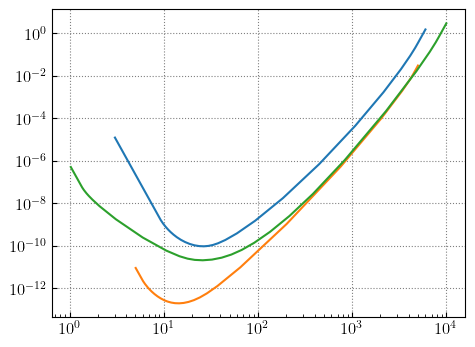

In [14]:
fig,ax = plt.subplots(figsize=(5.33,4))
ax.plot(freqs_Asharp, Asharp_pi)
ax.plot(freqs_CE, CE_pi)

ax.set_xscale('log')
ax.set_yscale('log')

## Plot for uniform merger rate 

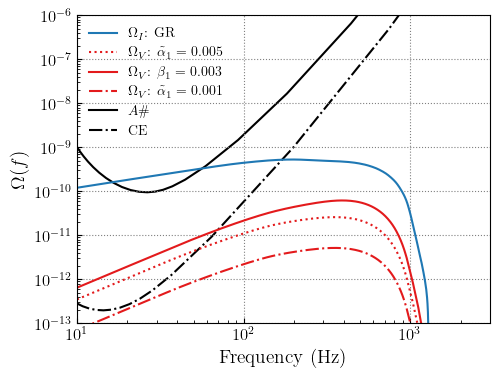

In [68]:
freqs = np.logspace(1,3.5,1000)
kappa_dc = 0.
kappa_z = 0.003
Omega_I_f_GR,Omega_V_f_GR = omg.eval(R0,dRdV_uniform,freqs,0,0)
Omega_I_f_CS,Omega_V_f_CS = omg.eval(R0,dRdV_uniform,freqs,0,0.001)
Omega_I_f_Dc,Omega_V_f_Dc = omg.eval(R0,dRdV_uniform,freqs,0.05,0)
Omega_I_f_maxDC,Omega_V_f_maxDC = omg.eval(R0,dRdV_uniform,freqs,0.0033,0)
Omega_I_f_maxz,Omega_V_f_maxz = omg.eval(R0,dRdV_uniform,freqs,0,0.005)

fig,ax = plt.subplots(figsize=(5.33,4))
ax.plot(freqs,Omega_I_f_GR,label='$\Omega_I$: GR',color=blue, linestyle='solid')
ax.plot(freqs,Omega_V_f_maxz,label='$\Omega_V$: $\\tilde{\\alpha}_1 = 0.005$', ls=":",color=red)
ax.plot(freqs,Omega_V_f_maxDC,label='$\Omega_V$: $\\beta_1 = 0.003$',color=red)
ax.plot(freqs,Omega_V_f_CS,label='$\Omega_V$: $\\tilde{\\alpha}_1 = 0.001$',color=red, linestyle='-.')
ax.plot(freqs_Asharp, Asharp_pi, color='black', label='$A\#$',zorder=1)
ax.plot(freqs_CE,CE_pi, color='black', label='CE', ls= "-.", zorder=1)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel("$\Omega(f)$")
ax.legend(loc='upper left',frameon=False,fontsize=10)
ax.set_ylim(1e-13,1e-6)
ax.set_xlim(10, 3000)
plt.show()
fig.savefig('TheoryPlot_uniform_Final.pdf')

## Plot for low-z delayed merger rate 

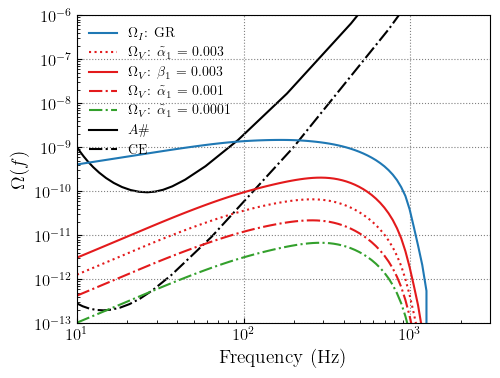

In [21]:
freqs = np.logspace(1,3.5,100)
kappa_dc = 0.
kappa_z = 0.003
Omega_I_f_GR,Omega_V_f_GR = omg.eval(R0,dRdV_lowZdelayed,freqs,0,0)
Omega_I_f_CS,Omega_V_f_CS = omg.eval(R0,dRdV_lowZdelayed,freqs,0,0.001)
Omega_I_f_Dc,Omega_V_f_Dc = omg.eval(R0,dRdV_lowZdelayed,freqs,0.05,0)
Omega_I_f_max_Dc,Omega_V_f_max_Dc = omg.eval(R0,dRdV_lowZdelayed,freqs,0.003,0)
Omega_I_f_max_z,Omega_V_f_max_z = omg.eval(R0,dRdV_lowZdelayed,freqs,0,0.003)

Omega_I_f_test,Omega_V_f_test = omg.eval(R0,dRdV_lowZdelayed,freqs,0.0001,0)

fig,ax = plt.subplots(figsize=(5.33,4))
ax.plot(freqs,Omega_I_f_GR,label='$\Omega_I$: GR',color=blue, linestyle='solid')
ax.plot(freqs,Omega_V_f_max_z,label='$\Omega_V$: $\\tilde{\\alpha}_1$ = 0.003', ls=":",color=red)
ax.plot(freqs,Omega_V_f_max_Dc,label='$\Omega_V$: $\\beta_1$ = 0.003',color=red)
ax.plot(freqs,Omega_V_f_CS,label='$\Omega_V$: $\\tilde{\\alpha}_1$ = 0.001',color=red, linestyle='-.')
#ax.plot(freqs,Omega_V_f_test,label='$\Omega_V$: $\\tilde{\\alpha}_1$ = 0.0001',color=green, linestyle='-.')
ax.plot(freqs_Asharp, Asharp_pi, color='black', label='$A\#$',  zorder=1)
ax.plot(freqs_CE,CE_pi, color='black', label='CE', ls= "-.", zorder=1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel("$\Omega(f)$")
ax.legend(loc='upper left',frameon=False,fontsize=10)
ax.set_ylim(1e-13,1e-6)
ax.set_xlim(10, 3000)
plt.show()
fig.savefig('TheoryPlot_lowzDelayed_Final.pdf')